 # Keras VGG19 Feature Extraction #

#### import necessary packages ####

In [2]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os

### Define the Feature Extraction Function ###

In [3]:
def extract_features(model, folder_path):
    # Get a list of all image files in the folder
    img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Use list comprehension to process images and extract features
    features = []
    for img_path in img_paths:
        try:
            img = image.load_img(img_path, target_size=model.input_shape[1:3])
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            feature = model.predict(img_array)
            features.append(feature)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    # Stack the extracted features into a single NumPy array
    features = np.vstack(features)

    return features

### Load Pre-trained VGG16 Model and Create Feature Extraction Model ###

In [4]:
# Load the pre-trained VGG19 model with top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=True, input_shape=(224, 224, 3)) # Adjust input_shape accordingly

# Create a new model that includes only the convolutional base of VGG19
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv4').output)


### Specify Folder Paths ###

In [5]:
# Specify folder paths for ASD and non-ASD child face image sets
asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD'
non_asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD'

### Extract features for ASD child faces ###

In [6]:
asd_features = extract_features(model, asd_folder_path)

2024-02-26 18:24:28.085805: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 409ms/step


###  Extract features for non-ASD child faces ###

In [7]:
non_asd_features = extract_features(model, non_asd_folder_path)

1/1 [==============================] - 0s 175ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/child-1617.png: cannot identify image file <_io.BytesIO object at 0x1460703b0>
1/1 [==============================] - 0s 168ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/additional1178.png: cannot identify image file <_io.BytesIO object at 0x1414043b0>
1/1 [==============================] - 0s 179ms/step


### Save the extracted features for later use in training ###

In [8]:
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/asd_features.npy', asd_features)
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/non_asd_features.npy', non_asd_features)

# Keras VGG19 Model Training #

### import necessary packages ###

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import load_model

### Load the extracted features for ASD and non-ASD child faces ###

In [48]:
asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/asd_features.npy')
non_asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/non_asd_features.npy')

### Assign labels (1 for ASD, 0 for non-ASD) ###

In [49]:
asd_labels = np.ones(asd_features.shape[0])
non_asd_labels = np.zeros(non_asd_features.shape[0])

### Combine features and labels ###

In [50]:
X = np.vstack([asd_features, non_asd_features])
y = np.concatenate([asd_labels, non_asd_labels])

### Shuffle the data ###

In [51]:
X, y = shuffle(X, y, random_state=42)

### Split the data into training and testing sets (70% training, 30% testing) ###

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model definition ###

In [53]:
# Model definition
model = Sequential()
model.add(Flatten(input_shape=(14, 14, 512)))  # Adjust input shape to match the flattened features
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model training ###

In [54]:
# Model training
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
175/175 [==============================] - 16s 87ms/step - loss: 3.2119 - accuracy: 0.8661 - val_loss: 0.2785 - val_accuracy: 0.8912
Epoch 2/100
175/175 [==============================] - 16s 89ms/step - loss: 0.2451 - accuracy: 0.8974 - val_loss: 0.2272 - val_accuracy: 0.9077
Epoch 3/100
175/175 [==============================] - 15s 86ms/step - loss: 0.2072 - accuracy: 0.9209 - val_loss: 0.2185 - val_accuracy: 0.9205
Epoch 4/100
175/175 [==============================] - 15s 87ms/step - loss: 0.1616 - accuracy: 0.9368 - val_loss: 0.2246 - val_accuracy: 0.9205
Epoch 5/100
175/175 [==============================] - 16s 89ms/step - loss: 0.1472 - accuracy: 0.9431 - val_loss: 0.2202 - val_accuracy: 0.9313
Epoch 6/100
175/175 [==============================] - 15s 85ms/step - loss: 0.1192 - accuracy: 0.9502 - val_loss: 0.2759 - val_accuracy: 0.9291
Epoch 7/100
175/175 [==============================] - 15s 85ms/step - loss: 0.1113 - accuracy: 0.9561 - val_loss: 0.2951 - val_ac

###  Save the trained model to a file named 'VGG19model.h5' ###

In [55]:
model.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/VGG19Model.h5')

### Model evaluation ###

In [56]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

94/94 [==============================] - 2s 23ms/step - loss: 1.5603 - accuracy: 0.9305
Test Accuracy: 0.9305277466773987


### Predictions ###

In [57]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype('int32')

94/94 [==============================] - 2s 23ms/step


### Classification report ###

In [58]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      2586
         1.0       0.81      0.64      0.72       408

    accuracy                           0.93      2994
   macro avg       0.88      0.81      0.84      2994
weighted avg       0.93      0.93      0.93      2994


### Confusion matrix ###

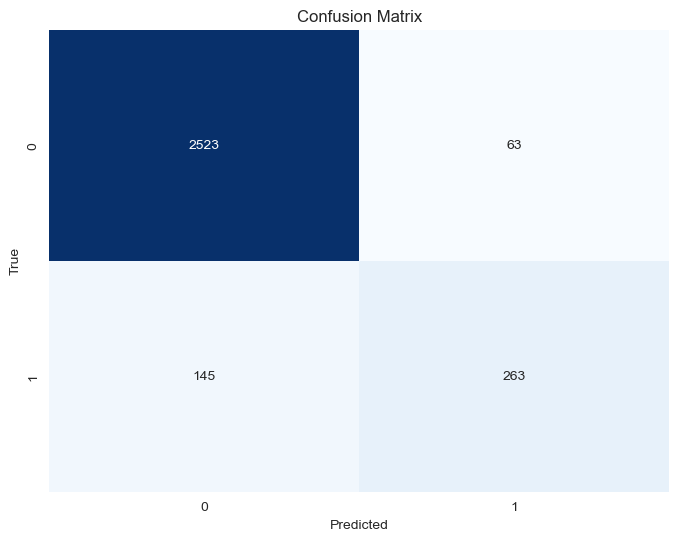

In [59]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Plot training history ###

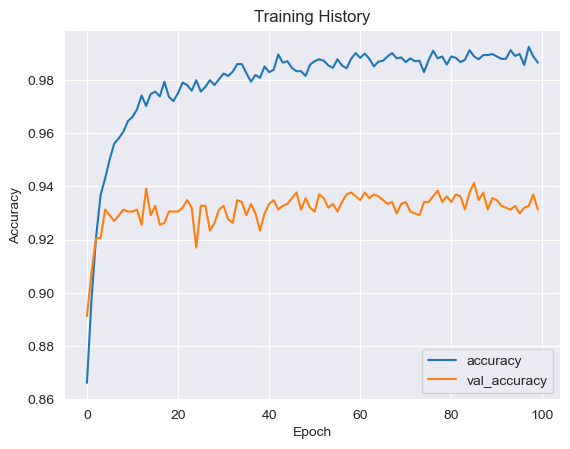

In [60]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.show()

# Keras VGG19 Prediction  #

### Importing Libraries ###

In [62]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skimage.segmentation import mark_boundaries
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import cv2
import numpy as np
from lime.lime_image import LimeImageExplainer

### Defining Paths and target size ###

In [63]:
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/VGG19Model.h5'
target_size = (224, 224)

### Load the pre-trained VGG19 model with top layers included ###

In [64]:
base_model = VGG19(weights='imagenet', include_top=True)

### Take the output of the base model up to the last convolutional layer ###

In [65]:
x = base_model.get_layer('block5_pool').output

### Add a new dense layer for output ###

In [66]:
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

### Create a new model that takes the input of VGG19 and outputs the desired layer ###

In [67]:
model = Model(inputs=base_model.input, outputs=predictions)

### Process the input image ###

In [68]:
img = cv2.imread(input_image_path)
img = cv2.resize(img, target_size) # Resize the image to (224, 224)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
img = np.expand_dims(img, axis=0) # Add a batch dimension
img = preprocess_input(img) # Preprocess the image

### Preprocess the image for the explainer by dividing pixel values by 255 ###

In [69]:
img_scaled = img / 255.0

### Predict ASD probability using the full VGG19 model ###

In [70]:
prediction = model.predict(img)[0][0] # Access the first element for ASD probability

rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")

1/1 [==============================] - 0s 234ms/step
Predicted probability: 0.84
Predicted ASD with probability: 0.84


# XAI LIME #

1/1 [==============================] - 0s 165ms/step
Predicted probability: 0.84
Predicted ASD with probability: 0.84


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


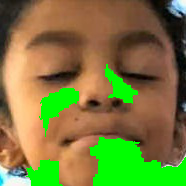

In [71]:
prediction = model.predict(img)[0][0] # Access the first element for ASD probability

rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

    explainer = LimeImageExplainer()

    # Generate an explanation for the prediction using the explainer object
    explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)

    # Visualize the explanation using matplotlib
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # Resize the explanation mask to match the original image dimensions
    mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)

    # Convert the mask to the original image mode
    original_image = Image.open(input_image_path)
    #original_image = original_image.convert("L")  # Convert the original image to grayscale
    original_width, original_height = original_image.size
    original_mode = original_image.mode

    # Overlay the explanation mask on the original image
    mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    original_image = np.array(original_image)
    original_image[mask > 0.5] = (0, 255, 0)



    # Display the original image with the explanation mask
    display(Image.fromarray(original_image))

else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")

# XAI Grad CAM #

### Import necessary libraries ###

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, load_model
import tensorflow as tf

### Define Grad-CAM function ###

In [3]:
def generate_grad_cam(model, img_array, layer_name):
    # Create a model that maps the input image to the desired layer's output
    grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))

    # Compute the gradient of the predicted class with respect to the output feature map of the given layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        predicted_class_output = preds[:, 0]  # ASD class index assuming ASD class is the first one

    grads = tape.gradient(predicted_class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Compute the heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

### Define paths ###

In [4]:
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0725.jpg' # Replace with your image path
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/test.jpeg' # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/VGG19Model.h5'
target_size = (224, 224)

### Load the pre-trained VGG16 model with top layers included ###

In [5]:
base_model = VGG16(weights='imagenet', include_top=True)

### Create a new model that takes the input of VGG16 and outputs the desired layer ###

In [6]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)

### Process the input image ###

In [7]:
img_original = cv2.imread(input_image_path)
img_original = cv2.resize(img_original, target_size)
img_for_model = preprocess_input(np.expand_dims(img_original, axis=0))

### Extract features using the full VGG16 model ###

In [8]:
features = model.predict(img_for_model)  # Use the new model

1/1 [==============================] - 0s 220ms/step


### Reshape features to match the expected input shape of trained_model ###

In [9]:
features_reshaped = np.reshape(features, (features.shape[0], 14, 14, 512))

### Load the trained model ###

In [10]:
trained_model = load_model(model_path)

### Predict ASD probability using the trained model and extracted features ###

In [11]:
prediction = trained_model.predict(features_reshaped)[0][0]

1/1 [==============================] - 0s 85ms/step


### Interpret the prediction ###

Prediction: 0.86391
Predicted ASD with probability: 0.86


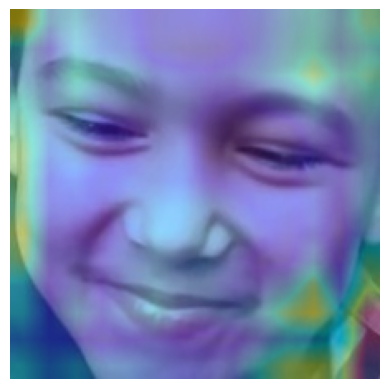

In [12]:
rounded_prediction = round(prediction, 2)
print("Prediction: {:.5f}".format(prediction))

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

    # Visualize the Grad-CAM heatmap
    heatmap = generate_grad_cam(model, img_for_model, 'block5_conv3')

    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

    # Apply colormap for better visualization
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)

    # Display the superimposed image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")


1/1 [==============================] - 0s 409ms/step
Predicted probability: 0.61
Predicted ASD with probability: 0.61


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


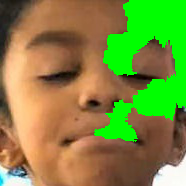

In [4]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from skimage.segmentation import mark_boundaries
# from keras.applications.vgg19 import preprocess_input
# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.preprocessing import image
# from PIL import Image
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# import cv2
# import numpy as np
# from lime.lime_image import LimeImageExplainer
# 
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
# model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/VGG19Model.h5'
# target_size = (224, 224)
# 
# # Load the pre-trained VGG19 model with top layers included
# base_model = VGG19(weights='imagenet', include_top=True)
# 
# # Take the output of the base model up to the last convolutional layer
# x = base_model.get_layer('block5_pool').output
# 
# # Add a new dense layer for output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid')(x)
# 
# # Create a new model that takes the input of VGG19 and outputs the desired layer/
# model = Model(inputs=base_model.input, outputs=predictions)
# 
# # # Load the trained model
# # model.load_weights(model_path)
# 
# # Process the input image
# img = cv2.imread(input_image_path)
# img = cv2.resize(img, target_size) # Resize the image to (224, 224)
# # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
# img = np.expand_dims(img, axis=0) # Add a batch dimension
# img = preprocess_input(img) # Preprocess the image
# 
# # Preprocess the image for the explainer by dividing pixel values by 255
# img_scaled = img / 255.0
# 
# # Predict ASD probability using the full VGG19 model
# prediction = model.predict(img)[0][0] # Access the first element for ASD probability
# 
# rounded_prediction = round(prediction, 2)
# print(f"Predicted probability: {rounded_prediction:.2f}")
# 
# if rounded_prediction > 0.5:
#     print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
# 
#     explainer = LimeImageExplainer()
# 
#     # Generate an explanation for the prediction using the explainer object
#     explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)
# 
#     # Visualize the explanation using matplotlib
#     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
# 
#     # Resize the explanation mask to match the original image dimensions
#     mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)
# 
#     # Convert the mask to the original image mode
#     original_image = Image.open(input_image_path)
#     #original_image = original_image.convert("L")  # Convert the original image to grayscale
#     original_width, original_height = original_image.size
#     original_mode = original_image.mode
# 
#     # Overlay the explanation mask on the original image
#     mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
#     original_image = np.array(original_image)
#     original_image[mask > 0.5] = (0, 255, 0)
# 
# 
# 
#     # Display the original image with the explanation mask
#     display(Image.fromarray(original_image))
# 
# else:
#     print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")

Epoch 1/100
175/175 [==============================] - 15s 83ms/step - loss: 2.2165 - accuracy: 0.8690 - val_loss: 0.2643 - val_accuracy: 0.8962
Epoch 2/100
175/175 [==============================] - 15s 84ms/step - loss: 0.2386 - accuracy: 0.9062 - val_loss: 0.2030 - val_accuracy: 0.9213
Epoch 3/100
175/175 [==============================] - 15s 83ms/step - loss: 0.2261 - accuracy: 0.9159 - val_loss: 0.2386 - val_accuracy: 0.9213
Epoch 4/100
175/175 [==============================] - 15s 87ms/step - loss: 0.1772 - accuracy: 0.9273 - val_loss: 0.2300 - val_accuracy: 0.9205
Epoch 5/100
175/175 [==============================] - 15s 84ms/step - loss: 0.1437 - accuracy: 0.9271 - val_loss: 0.2307 - val_accuracy: 0.9234
Epoch 6/100
175/175 [==============================] - 15s 85ms/step - loss: 0.1307 - accuracy: 0.9295 - val_loss: 0.2814 - val_accuracy: 0.9205
Epoch 7/100
175/175 [==============================] - 14s 82ms/step - loss: 0.1064 - accuracy: 0.9393 - val_loss: 0.3155 - val_ac

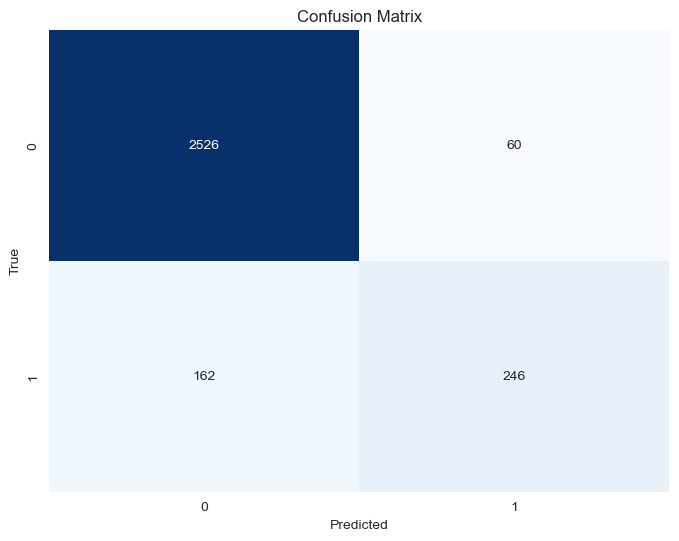

AttributeError: module 'IPython.core.magics.history' has no attribute 'history'

In [26]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.models import load_model
# 
# # Load the extracted features for ASD and non-ASD child faces
# asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/asd_features.npy')
# non_asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/non_asd_features.npy')
# 
# # Assign labels (1 for ASD, 0 for non-ASD)
# asd_labels = np.ones(asd_features.shape[0])
# non_asd_labels = np.zeros(non_asd_features.shape[0])
# 
# # Combine features and labels
# X = np.vstack([asd_features, non_asd_features])
# y = np.concatenate([asd_labels, non_asd_labels])
# 
# # Shuffle the data
# X, y = shuffle(X, y, random_state=42)
# 
# # Split the data into training and testing sets (70% training, 30% testing)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# 
# # Model definition
# model = Sequential()
# model.add(Flatten(input_shape=(14, 14, 512)))  # Adjust input shape to match the flattened features
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# 
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 
# # Model training
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
# 
# # Save the trained model to a file named 'model.h5'
# model.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/VGG19Model.h5')
# 
# # Model evaluation
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {test_accuracy}')
# 
# y_pred = model.predict(X_test)
# y_pred_classes = (y_pred > 0.5).astype('int32')
# 
# print(classification_report(y_test, y_pred_classes))
# 
# cm = confusion_matrix(y_test, y_pred_classes)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()
# 
# # Plot training history
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training History')
# plt.show()


Epoch 1/100
175/175 [==============================] - 15s 82ms/step - loss: 3.1842 - accuracy: 0.8786 - val_loss: 0.2397 - val_accuracy: 0.9205
Epoch 2/100
175/175 [==============================] - 14s 82ms/step - loss: 0.1928 - accuracy: 0.9406 - val_loss: 0.3352 - val_accuracy: 0.9191
Epoch 3/100
175/175 [==============================] - 14s 82ms/step - loss: 0.1258 - accuracy: 0.9599 - val_loss: 0.2467 - val_accuracy: 0.9356
Epoch 4/100
175/175 [==============================] - 14s 82ms/step - loss: 0.0944 - accuracy: 0.9678 - val_loss: 0.3089 - val_accuracy: 0.9320
Epoch 5/100
175/175 [==============================] - 15s 83ms/step - loss: 0.1037 - accuracy: 0.9669 - val_loss: 0.3253 - val_accuracy: 0.9334
Epoch 6/100
175/175 [==============================] - 15s 85ms/step - loss: 0.0790 - accuracy: 0.9724 - val_loss: 0.3291 - val_accuracy: 0.9313
Epoch 7/100
175/175 [==============================] - 15s 83ms/step - loss: 0.0524 - accuracy: 0.9805 - val_loss: 0.3668 - val_ac

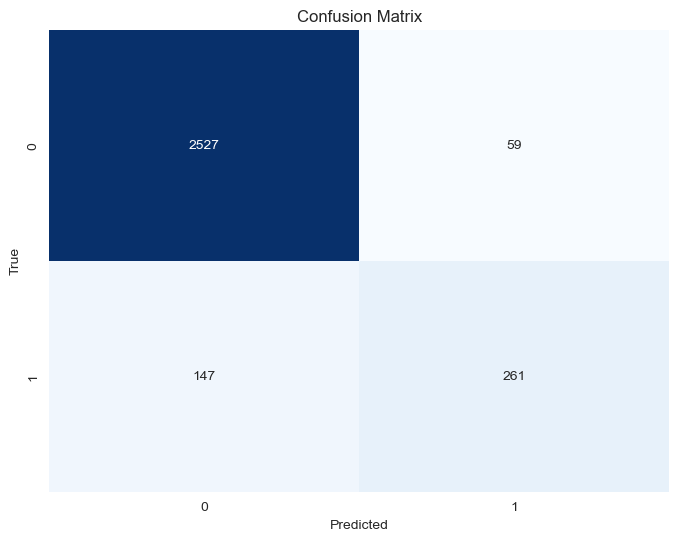

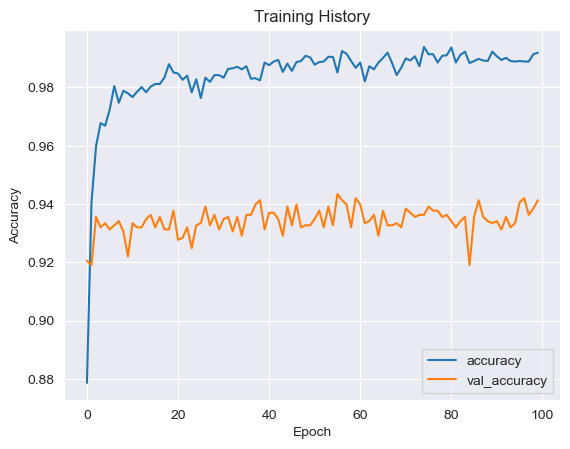

In [27]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.models import load_model
# 
# # Load the extracted features for ASD and non-ASD child faces
# asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/asd_features.npy')
# non_asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/non_asd_features.npy')
# 
# # Assign labels (1 for ASD, 0 for non-ASD)
# asd_labels = np.ones(asd_features.shape[0])
# non_asd_labels = np.zeros(non_asd_features.shape[0])
# 
# # Combine features and labels
# X = np.vstack([asd_features, non_asd_features])
# y = np.concatenate([asd_labels, non_asd_labels])
# 
# # Shuffle the data
# X, y = shuffle(X, y, random_state=42)
# 
# # Split the data into training and testing sets (70% training, 30% testing)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# 
# # Model definition
# model = Sequential()
# model.add(Flatten(input_shape=(14, 14, 512)))  # Adjust input shape to match the flattened features
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# 
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 
# # Model training
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
# 
# # Save the trained model to a file named 'model.h5'
# model.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/VGG19Model.h5')
# 
# # Model evaluation
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {test_accuracy}')
# 
# y_pred = model.predict(X_test)
# y_pred_classes = (y_pred > 0.5).astype('int32')
# 
# print(classification_report(y_test, y_pred_classes))
# 
# cm = confusion_matrix(y_test, y_pred_classes)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()
# 
# # Plot training history
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training History')
# plt.show()


1/1 [==============================] - 0s 205ms/step


2024-02-27 23:30:55.596227: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 58ms/step
Prediction: 0.86391
Predicted ASD with probability: 0.86


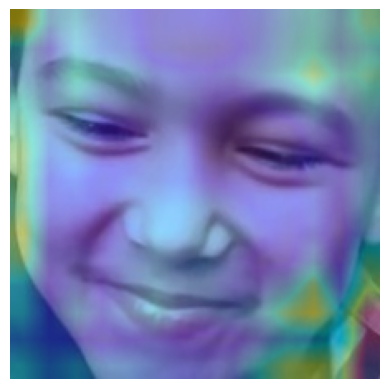

In [1]:
# import cv2
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.models import Model, load_model
# import tensorflow as tf
# 
# # Define Grad-CAM function
# def generate_grad_cam(model, img_array, layer_name):
#     # Create a model that maps the input image to the desired layer's output
#     grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))
# 
#     # Compute the gradient of the predicted class with respect to the output feature map of the given layer
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         predicted_class_output = preds[:, 0]  # ASD class index assuming ASD class is the first one
# 
#     grads = tape.gradient(predicted_class_output, last_conv_layer_output)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     last_conv_layer_output = last_conv_layer_output[0]
# 
#     # Compute the heatmap
#     heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
#     heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
#     heatmap /= np.max(heatmap)  # Normalize
# 
#     return heatmap
# 
# # Define paths
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0725.jpg' # Replace with your image path
# # input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/test.jpeg' # Replace with your image path
# model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG19/VGG19Model.h5'
# target_size = (224, 224)
# 
# # Load the pre-trained VGG16 model with top layers included
# base_model = VGG16(weights='imagenet', include_top=True)
# 
# # Create a new model that takes the input of VGG16 and outputs the desired layer/
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
# 
# # Process the input image
# img_original = cv2.imread(input_image_path)
# img_original = cv2.resize(img_original, target_size)
# img_for_model = preprocess_input(np.expand_dims(img_original, axis=0))
# 
# # Extract features using the full VGG16 model
# features = model.predict(img_for_model)  # Use the new model
# 
# # Reshape features to match the expected input shape of trained_model
# features_reshaped = np.reshape(features, (features.shape[0], 14, 14, 512))  # Reshape to (None, 14, 14, 512)
# 
# # Load the trained model
# trained_model = load_model(model_path)
# 
# # Predict ASD probability using the trained model and extracted features
# prediction = trained_model.predict(features_reshaped)[0][0]  # Access the first element for ASD probability
# 
# # Interpret the prediction
# rounded_prediction = round(prediction, 2)
# print("Prediction: {:.5f}".format(prediction))
# 
# if rounded_prediction > 0.5:
#     print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
# 
#     # Visualize the Grad-CAM heatmap
#     heatmap = generate_grad_cam(model, img_for_model, 'block5_conv3')
# 
#     # Resize heatmap to match the size of the original image
#     heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))
# 
#     # Apply colormap for better visualization
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 
#     # Superimpose the heatmap on the original image
#     superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)
# 
#     # Display the superimposed image
#     plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()
# 
# else:
#     print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")
